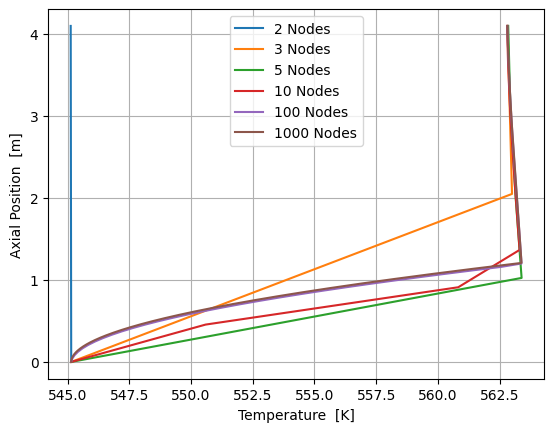

	Maximum Temperatures
------------------------------------
Fuel: 2348.405535261496
Clad: 642.4920686644296
Fluid: 563.3837684271507


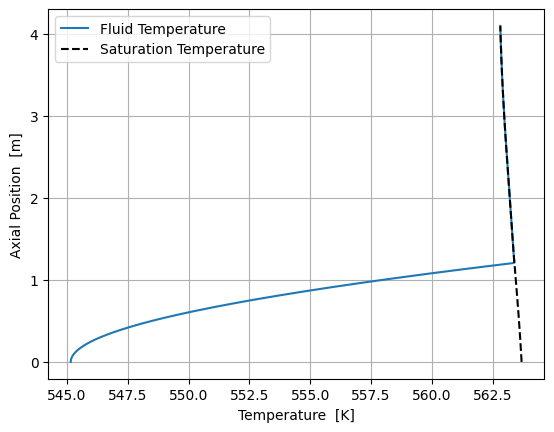

onb: 0.3406406406406406
satboil: 1.207895473292037


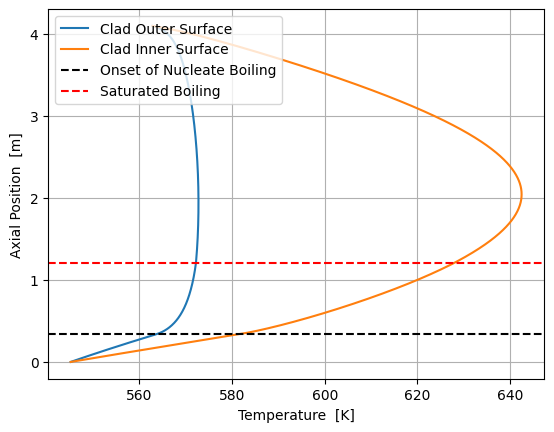

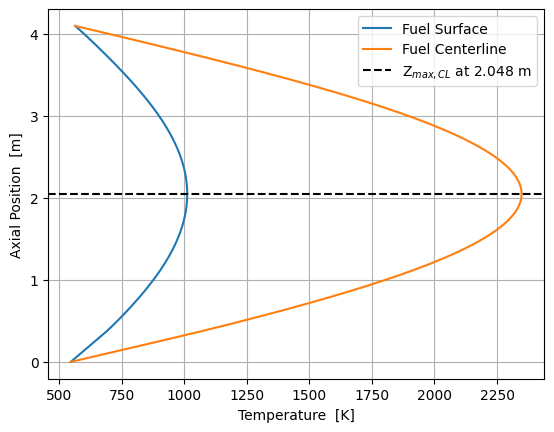

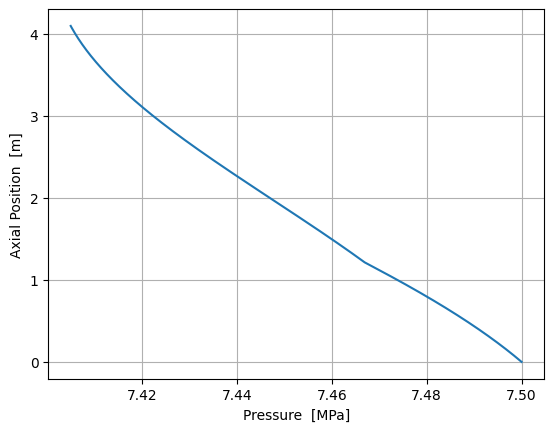

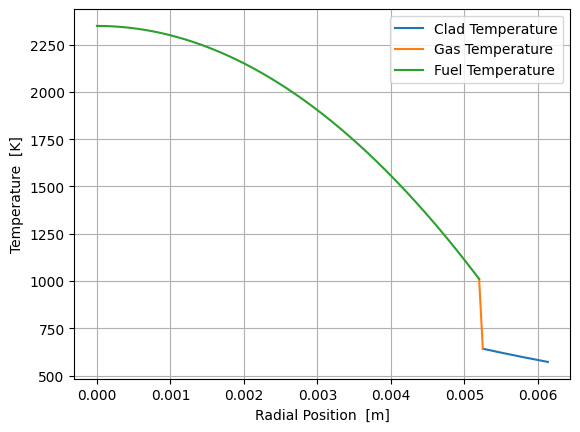

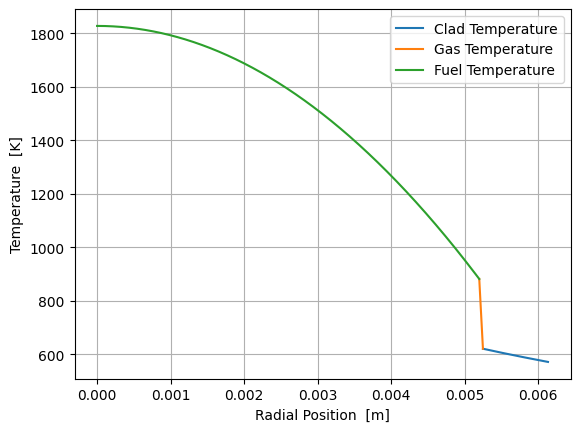

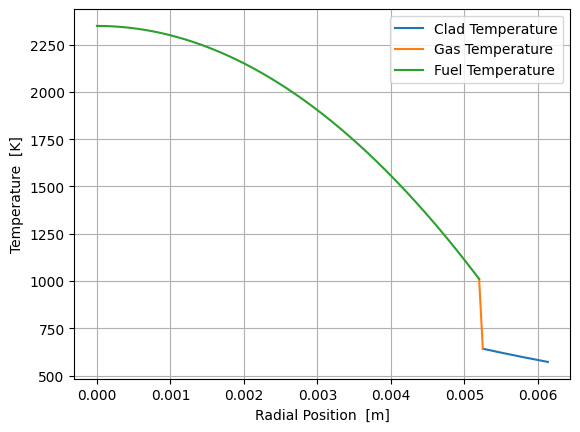

zmax: 2.047947947947948


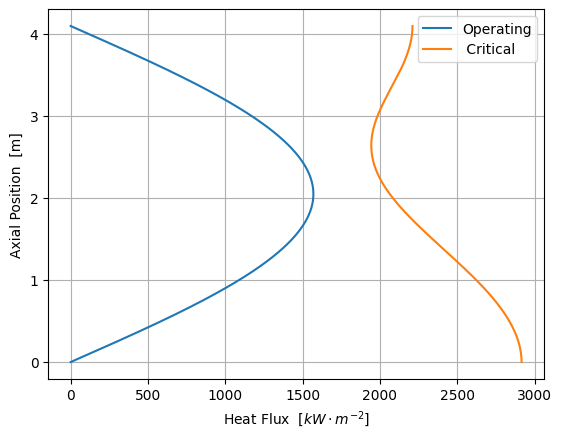

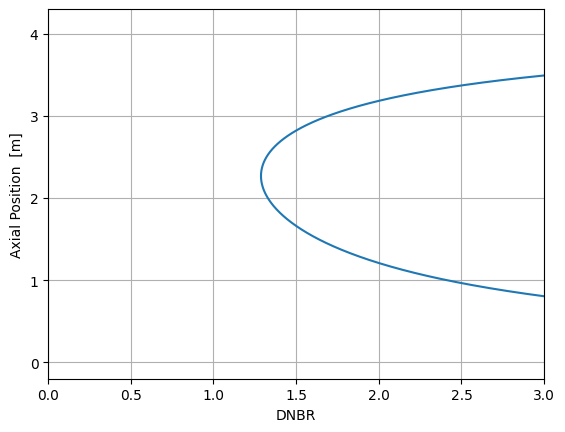

dnbr: 1.2873237247176776


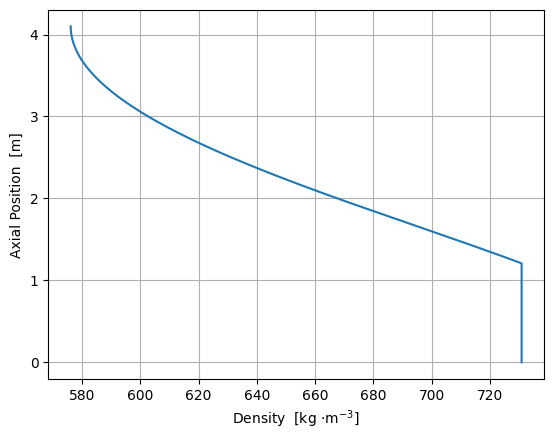

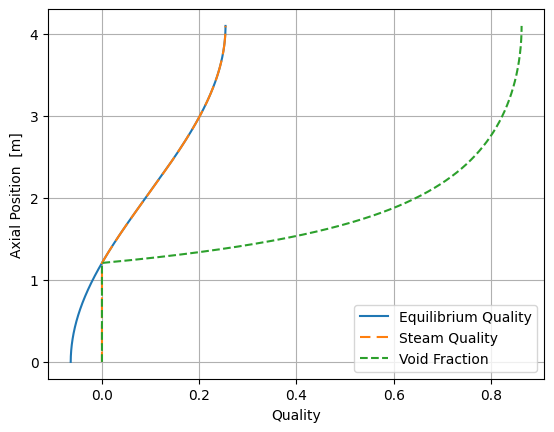

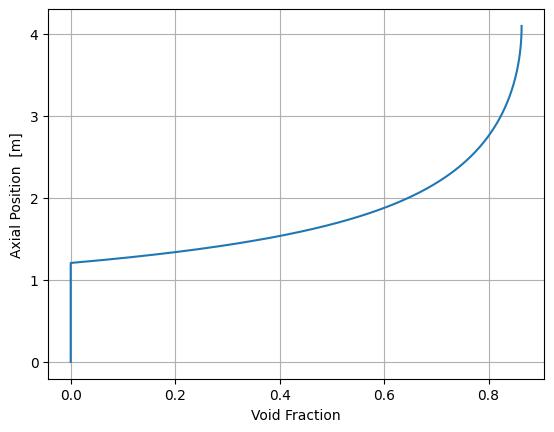

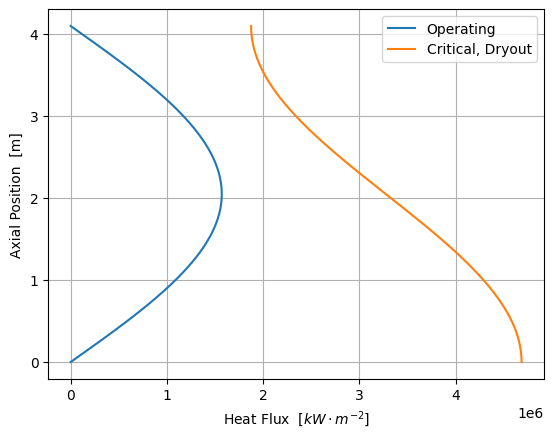

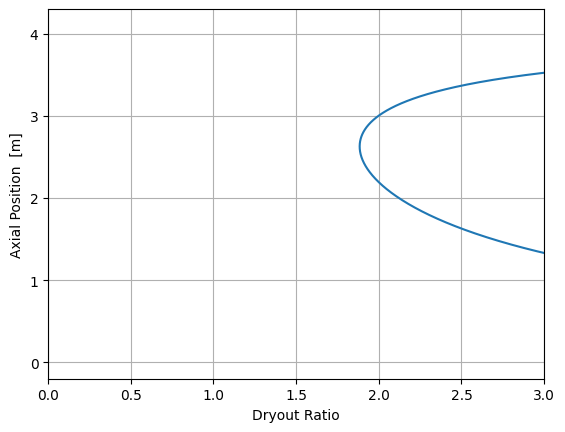

dr: 1.8841524960502785


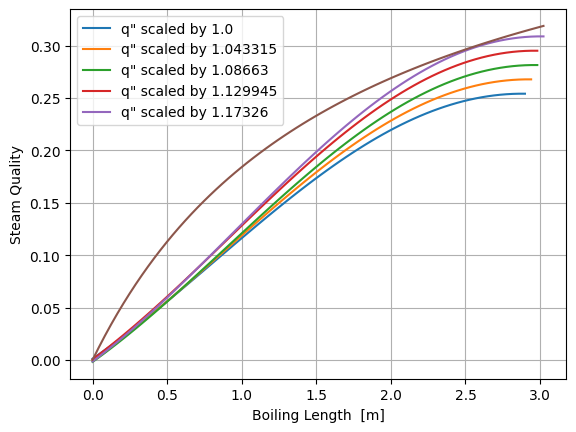




	    Sensitivity
-----------------------------------
\toprule
\bottomrule
q'_{0}  [$W\cdotcm^{-1}$] & 302.5 & 453.75 & 605.0 & 756.25 & 907.5 \\
\hline
T_{max,CL}  [$K$] & 1458.415 & 1903.436 & 2348.186 & 2792.779 & 3237.268 \\
\toprule
\bottomrule
G  [$kg\cdot m^{-2} \cdot s^{-1}$] & 1175.0 & 1762.5 & 2350.0 & 2937.5 & 3525.0 \\
\hline
T_{max,CL}  [$K$] & 2348.155 & 2348.209 & 2348.186 & 2348.104 & 2347.977 \\
\toprule
\bottomrule
T_{f,in}  [$K$] & 450.94939068941744 & 479.133727607506 & 507.3180645255946 & 535.5024014436831 & 558.049870978154 \\
\hline
T_{max,CL}  [$K$] & 2344.106 & 2346.634 & 2347.937 & 2348.145 & 2348.254 \\
\toprule
\bottomrule
P_{in}  [$MPa$] & 5.625 & 6.5625 & 7.5 & 8.4375 & 9.375 \\
\hline
T_{max,CL}  [$K$] & 2331.805 & 2339.879 & 2348.186 & 2355.734 & 2362.664 \\


In [1]:


'''PLEASE CHANGE THIS'''
option = 'BWR' # options are 'PWR' or 'BWR'

'''^^^^^^^^^^^^^^^^^^'''
'''^^^^^^^^^^^^^^^^^^'''
'''^^^^^^^^^^^^^^^^^^'''
'''^^^^^^^^^^^^^^^^^^'''
'''^^^^^^^^^^^^^^^^^^'''

import numpy as np
from numpy.linalg import norm as norm
import scipy as scp
import matplotlib.pyplot as plt
from pyXSteam.XSteam import XSteam
np.set_printoptions(precision=3,suppress= True)
import warnings
warnings.filterwarnings("ignore") 

class Conditions:
    
    def __init__(self,which = 'PWR'):
        
        self.g = 9.81 # m/s2
        
        if which == 'PWR':
            self.G = 4000 #kg/m2 s
            self.qp0 = 430e2 #W/cm to W/m
            self.P0 = 15e6 #MPa to pa
            self.Tf0c = 277 #oC
        
        else:
            self.G = 2350 #kg/m2 s
            self.qp0 = 605e2 #W/cm to W/m
            self.P0 = 7.5e6 #MPa to pa
            self.Tf0c = 272 #oC
            
        self.Tf0 = self.Tf0c + 273.15

class PinProperties:
    
    def __init__(self,Conditions,which = 'PWR'):
    
        if which == 'PWR':
            
            self.H = 4 #m
            self.Drod = 0.95e-2 # cm to m 
            self.Pitch = 1.26e-2 # cm to m
            self.DFuel = 0.82e-2 # cm to m
            self.Gap_thickness = 0.006e-2 #cm to m
            self.kgap=0.25 #W/mK
            self.k_fuel=3.6 #W/mK
            self.k_cladding=21.5 #W/mK
            #self.mu = 97.575e-6
            self.muL = lambda a: 69.403e-6
            self.muV = lambda a: 22.716e-6
        
        else:
            
            self.H = 4.1 #m
            self.Drod = 1.227e-2 # cm to m
            self.Pitch = 1.62e-2 # cm to m 
            self.DFuel = 1.04e-2 # cm to m 
            self.Gap_thickness = 0.010e-2 # cm to m
            self.kgap=0.25 #W/mK
            self.k_fuel=3.6 #W/mK
            self.k_cladding=21.5 #W/mK
            #self.mu = 97.352e-6
            self.muL = lambda a: 89.451e-6
            self.muV = lambda a: 11.656e-6

        
        self.xih = self.Drod * np.pi #m
        self.SAf = self.DFuel *np.pi * self.H
        self.SAc = (self.DFuel + self.Gap_thickness) * np.pi * self.H
        self.Axsf = self.DFuel ** 2 / 4 * np.pi
        self.Rf = self.DFuel/2
        self.Rci = self.Rf + self.Gap_thickness/2
        self.Rco = self.Drod / 2 
        self.qp = lambda z: Conditions.qp0* np.sin(np.pi * z / self.H) #W/m
        self.qpp = lambda z: self.qp(z) / self.xih # w /m2
        self.q3p = lambda z: self.qp(z) / self.Axsf
        
        return

class FluidProperties:
    
    def __init__(self,ICs,Pin,poly_order=15):
        
        '''
        Steam Table
        -----------
        '''
        props = XSteam(XSteam.UNIT_SYSTEM_BARE)
        
        '''
        Constant Material Properties 
        ----------------------------
        '''
        _p0,_tf0 = ICs.P0/1e6,ICs.Tf0 # Initial Pressure [MPa] and Temp [K]
        self.cp = props.Cp_pt(_p0,_tf0) * 1e3 #kj/kg -> j/kg
        self.mu = props.my_pt(_p0,_tf0)  # N s / m2
        self.k = props.tc_pt(_p0,_tf0)  # W/ m K

        '''
        Pressure Variant Properties
        ---------------------------
        '''
        self.hg = lambda P: props.hV_p(P) * 1e3 # kJ/kg -> j/kg
        self.hf = lambda P: props.hL_p(P) * 1e3 # kJ/kg -> j/kg
        self.hfg = lambda P: self.hg(P) - self.hf(P)
        self.tsat = lambda P: props.tsat_p(P) # K

        '''
        Initial Properties
        ------------------
        '''
        self.X_e0 = self.cp*(_tf0 - self.tsat(_p0))/self.hfg(_p0)
        self.rho0 = props.rho_pt(_p0,_tf0) #kg /m3

        '''
        Pipe Dimensions
        ---------------
        '''
        self.Area = (Pin.Pitch**2 - 1/4 * np.pi * Pin.Drod**2) #m2
        self.xiw = Pin.xih #m
        self.Dh = 4 * self.Area / (self.xiw) #m
        
        '''
        Dimensionless Groups + UPDATE, should be changing in z
        ----------------------
        '''
        self.Re = lambda Xe, P: ICs.G * self.Dh / self.mu#m(Xe,P)
        self.Pr = lambda Xe, P: self.cp * self.mu / self.k
        self.Nu = lambda Xe, P: 0.023 * self.Re(Xe, P)**(.8) * self.Pr(Xe, P) ** (0.4)
        self.h = lambda Xe, P: self.Nu(Xe, P) * self.k / self.Dh 
        self.__f = lambda Xe, P: self.Re(Xe, P) ** (-.25) * 0.316

        '''
        Two-Phase Properties
        --------------------
        '''
        self.rhosatratio = lambda P: props.rhoV_p(P) / props.rhoL_p(P)
        self.alpha = lambda Xe: 1 / (1 + (Xe**(-1) - 1) * self.rhosatratio(_p0))
        self.rhofg = props.rhoL_p(_p0) - props.rhoV_p(_p0)
        self.vgf = -1/props.rhoL_p(_p0) + 1/props.rhoV_p(_p0)
        self.rhoL = props.rhoL_p(_p0)
        self.rhoV = props.rhoV_p(_p0)
        self.rhom = lambda Xe, P: self.rhoL if Xe<0 else (1/self.rhoL + 1/self.rhofg*Xe)**(-1)
            #for props.my_pt, for whatever reason pyXSteam doesnt have mu at saturation
            #so you have to alter tsat a littlebit
        self.mum = lambda Xe, P: Pin.muL(P) if Xe <0 else (Xe / Pin.muV(P) + (1 - Xe)/Pin.muL(P))**(-1)
        self.f = lambda Xe, P: self.__f(Xe,P) if Xe < 0 else 0.046 * self.Re(Xe,P)**(-0.2) * (self.mum(Xe, P) / Pin.muL(P)) **(0.2)


        '''
        Material Property Fits
        ----------------------
        '''
        self.__pressures = np.linspace(1,20,1000)
        self.__hf_data = [self.hf(P) for P in self.__pressures] 
        self.__hg_data = [self.hg(P) for P in self.__pressures]

        #fitting with 15th order polynomial with numpy.polyfit and np.polynomial.Polynomials
        #polyfit returns high -> low, polynomial.Polynomial takes low -> high 
        #only setting as object for plotting
        self.__hf_fit = np.polynomial.Polynomial( np.flip( np.polyfit(self.__pressures*1e6,self.__hf_data,poly_order) ) ) 
        self.__hg_fit = np.polynomial.Polynomial( np.flip( np.polyfit(self.__pressures*1e6,self.__hg_data,poly_order) ) ) 

        self.dhfdp = self.__hf_fit.deriv()
        self.dhgdp = self.__hg_fit.deriv()
        
        return

    def plot(self):
        
        p,hfdata,hgdata = self.__pressures, self.__hf_data, self.__hg_data
        hf_fit = self.__hf_fit(p*1e6)
        hg_fit = self.__hg_fit(p*1e6)

        hf_norm = norm(hf_fit - hfdata,2) / norm(hfdata,2)
        hg_norm = norm(hg_fit - hgdata,2) / norm(hgdata,2)
        
        fig,ax = plt.subplot_mosaic([['h_f','h_g']],figsize = (12,5),gridspec_kw={'wspace':.2})
        
        ax['h_f'].plot(p, hfdata, label = 'pyXSteam Data')
        ax['h_f'].plot(p, hf_fit, label = 'h$_f$ Polynomial Fit')
        ax['h_f'].set_ylabel('h$_f$  [J $\cdot$ kg$^{-1}$]')

        ax['h_g'].plot(p, hgdata, label = 'pyXSteam Data')
        ax['h_g'].plot(p, hg_fit, label= 'h$_{g}$ Polynomial Fit')
        ax['h_g'].set_ylabel('h$_{g}$  [J $\cdot$ kg$^{-1}$]')

        for plot in ax:
            ax[plot].set_xlabel('Pressure  [MPa]')
            ax[plot].grid()
            ax[plot].legend()

        print(f'hf Fit L2 Norm: {hf_norm}\nhg Fit L2 Norm: {hg_norm}')
        
        
        return 
        
'''
SOLVER
'''
class Solver:
    
    def __init__(self,which = 'PWR',num_zsteps = 100,param=None,val=None):
        try:
            assert(which in ['PWR','BWR'])
        except AssertionError:
            errormessage = f"The reactor type '{which}' is not supported. Valid reactor types are: 'BWR' or 'PWR'"
            raise Exception(errormessage)
        self.which = which
        self.ICs = Conditions(which=which)
        if param != None:
            self.ICs.__dict__[param] = val
        self.pin = PinProperties(which=which,Conditions=self.ICs)
        self.fluid = FluidProperties(self.ICs,self.pin)
        self.z = np.linspace(0,self.pin.H,num_zsteps)
        
        return


    def solveFluid(self,output = True):
        
        ICs,pin, fluid = self.ICs, self.pin, self.fluid
        z = self.z
        P = [ICs.P0]
        X_e = [fluid.X_e0]
        T_f = [ICs.Tf0]
        if output:
            print('Z-Coordinate\tPressure\tSteam Quality\tFluid Temperature')
            print('-----------------------------------------------------------------')
            print(f'{np.trunc(z[0],)}\t\t{np.around(P[0]*1e-6,3)}\t\t{np.around(X_e[0],4)}\t\t{np.around(T_f[0],3)}')
        for i in range(1, len(z)):
            
            dz = z[i]- z[i-1]
            
            '''
            Solving for Pressure
            Solve for pressure using the material properties at the previous z
            '''
            rhom = fluid.rhom(X_e[i-1],P[i-1]*1e-6)
            f = fluid.f(X_e[i-1],P[i-1]*1e-6)
            topP1 = 1/2 * fluid.xiw / fluid.Area * f * ICs.G**2 / rhom
            topP2 = rhom * ICs.g
            topP3 = ICs.G * pin.qp(z[i]) * fluid.vgf/ ( fluid.Area * fluid.hfg(P[i-1]*1e-6))
            botP1 =  fluid.dhfdp(P[i-1]) if X_e[i-1] < 0 else X_e[i-1] * fluid.dhgdp(P[i-1]) + (1-X_e[i-1]) * fluid.dhfdp(P[i-1])
            botP2 = 1 - ICs.G**2 * fluid.vgf/ (fluid.hfg(P[i-1]*1e-6)) * botP1
            insideP = (topP1 + topP2 + topP3) / botP2
            P_i = P[i-1] - dz *insideP

            '''
            Solving for Steam Quality
            Solve for steam quality using current pressure
            '''
            dpdz = (P_i - P[i-1]) / dz
            insideXe1 = fluid.dhfdp(P_i) * dpdz if X_e[i-1] < 0 else X_e[i-1] * fluid.dhgdp(P_i) * dpdz + (1 - X_e[i-1]) * fluid.dhfdp(P_i) * dpdz
            insideXe2 = pin.qp(z[i]) / (fluid.Area * ICs.G * fluid.hfg(P_i* 1e-6)) - 1/fluid.hfg(P_i * 1e-6) * insideXe1
            X_e_i = dz * insideXe2 + X_e[i-1]

            '''
            Solving for Temperature
            Find temperature with current properties
            '''
            T_f_i = fluid.hfg(P_i*1e-6) / fluid.cp * X_e_i + fluid.tsat(P_i*1e-6) if X_e_i < 0 else fluid.tsat(P_i*1e-6)

            '''
            Printing
            '''
            if output:
                print(f'{np.around(z[i],3)}\t\t{np.around(P_i*1e-6,3)}\t\t{np.around(X_e_i,4)}\t\t{np.around(T_f_i,3)}')
            
            '''
            Appending Pressure, Steam Quality, and Fluid Temperature lists
            lists are better than numpy arrays for on the fly changing...
            '''
            P.append(P_i)
            X_e.append(X_e_i)
            T_f.append(T_f_i)
            
        
        self.PFunc = scp.interpolate.interp1d(z,np.array(P)*1e-6)
        self.XeFunc = scp.interpolate.interp1d(z,X_e)
        self.TFluidFunc = scp.interpolate.interp1d(z,T_f)
        
        return


    def __solveCladSurface(self):

        ICs, pin, fluid = self.ICs, self.pin, self.fluid

        Pc = 22.064
        M = 18.01528
        F = lambda Xe,P: 1 if Xe < 0 else (1 + Xe * fluid.Pr(Xe,P) * (fluid.rhosatratio(P) - 1)) ** (0.35)
        S = lambda Xe,z: (1 + 0.055 * F(Xe,self.PFunc(z)) ** (0.1) * (fluid.Re(Xe, self.PFunc(z)))**(0.16)) ** (-1)
        hnb = lambda z: 55 * (self.PFunc(z) / Pc) ** (0.12) * pin.qpp(z)**(2/3) * (-np.log10(self.PFunc(z)/Pc))**(-0.55) * M**(-0.5)
        def twophase(Tw,z,Xe):
            P = self.PFunc(z)
            fpart = (F(Xe,P) * fluid.h(Xe, P) * (Tw - self.TFluidFunc(z)))**2
            spart = (S(Xe,z) * hnb(z) *(Tw - fluid.tsat(self.PFunc(z))))**2
            return pin.qpp(z) - (fpart + spart) **(.5)
        def onephase(z,Xe):
            P = self.PFunc(z)
            return pin.qpp(z) / fluid.h(Xe,P) + self.TFluidFunc(z)

        T_cs = []
        guess = fluid.tsat(ICs.P0/1e6) #* 1.5
        for i,z in enumerate(self.z):
            X_e_i = self.XeFunc(z)
            tempGuess = onephase(z, X_e_i)
            if tempGuess < fluid.tsat(self.PFunc(z)):
                T_cs.append(tempGuess)
            else:
                try:
                    _ = self.ONB * 3
                except:
                    self.ONB = z
                func = lambda Tw: twophase(Tw,z,X_e_i)
                root = scp.optimize.root(func,guess).x[0]
                T_cs.append(root)

        try:
            self.SatBoil = scp.optimize.root(self.XeFunc, pin.H/3).x[0]
        except ValueError:
            pass
        self.TCladS = scp.interpolate.interp1d(self.z,T_cs)
        return
            

    def solvePinTemperature(self):

        self.__solveCladSurface()
        ICs,pin, fluid = self.ICs, self.pin, self.fluid

        C3 = lambda z: -pin.q3p(z)*pin.Rf**2 / 2 / pin.kgap #yes
        C5 = lambda z: pin.kgap / pin.k_cladding * C3(z) 
        C6 = lambda z: self.TCladS(z) - C5(z)*np.log(pin.Rco)
        C4 = lambda z: C5(z)* np.log(pin.Rci) - C3(z)* np.log(pin.Rci) + C6(z)
        C2 = lambda z: pin.q3p(z) * pin.Rf**2 / 4 / pin.k_fuel + C3(z) * np.log(pin.Rf) + C4(z)

        self.TFuelFunc = lambda r, z: -pin.q3p(z) * r**2 / 4 / pin.k_fuel + C2(z)
        self.TGapFunc = lambda r, z: C3(z) * np.log(r) + C4(z)
        self.TCladFunc = lambda r, z: C5(z) * np.log(r) + C6(z)
        
        return
        

class Plotter:
    
    def __init__(self, which = 'PWR', ideal_steps = 1000, show = False):

        self.zsteps = ideal_steps
        solver = Solver(which=which,num_zsteps=self.zsteps)
        solver.solveFluid(output=False)
        solver.solvePinTemperature()
        self.solution = solver
        self.savepath = which + 'plots/'
        try:
            assert(which in ['PWR','BWR'])
        except AssertionError:
            errormessage = f"The reactor type '{which}' is not supported. Valid reactor types are: 'BWR' or 'PWR'"
            raise Exception(errormessage)
        self.__MESH(which,show)
        self.__BOTH(show)
        if which == 'BWR':
            self.__BWR(show)
        self.__SENSITIVITY(which)
        return
    def __finisher(self, ax, xlabel='t',legend=0,loc=None):
        xlabel = 'Temperature  [K]' if xlabel == 't' else 'Pressure  [MPa]'
        ax.grid()
        if legend:
            ax.legend(loc = loc)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Axial Position  [m]')
    def __radfinisher(self, ax):
        ax.grid()
        ax.legend()
        ax.set_xlabel('Radial Position  [m]')
        ax.set_ylabel('Temperature  [K]')

    
    def __show(self,show,name):
        plt.savefig(self.savepath+name+'.png', dpi=600)
        if show:
            plt.show()
        else:
            plt.close()
        
    @staticmethod   
    def __latex(arr, name):
        component = f'{name} & '
        maxcl = 'T_{max,CL}  [$K$] & '
        for comp, tcl in arr:
            component += str(comp) + ' & '
            maxcl += str(np.around(tcl,3)) + ' & '

        print('\\toprule\n\\bottomrule')
        print(component[:-2]+'\\\\')
        print('\hline')
        print(maxcl[:-2]+'\\\\')
        
        return


    def __MESH(self, which,show =False):
        fig, ax = plt.subplots()
        for n in [2,3,5,10,100, 1000]:
            solve = Solver(which,n)
            solve.solveFluid(output=False)
            ax.plot(solve.TFluidFunc(solve.z), solve.z, label = f'{n} Nodes')
        self.__finisher(ax,legend=1)
        self.__show(show,'mesh')
        return

    def __BOTH(self, show = False):

        solution = self.solution
        z = solution.z

        TFluid = solution.TFluidFunc(z)
        TCladSO = solution.TCladS(z)
        TCladSI = solution.TCladFunc(solution.pin.Rci,z)
        TFuelS = solution.TFuelFunc(solution.pin.Rf,z)
        TFuelCL = solution.TFuelFunc(0,z)

        print('\tMaximum Temperatures')
        print('------------------------------------')
        print(f'Fuel: {max(TFuelCL)}\nClad: {max(TCladSI)}\nFluid: {max(TFluid)}')
        zmaxCL = z[np.where(TFuelCL == max(TFuelCL))[0][0]]
        Pressure = solution.PFunc(z)
        TSat = [solution.fluid.tsat(p) for p in Pressure]

        '''Temperatures'''
        fig, ax = plt.subplots()
        ax.plot(TFluid,z, label = 'Fluid Temperature')
        ax.plot(TSat, z, label = 'Saturation Temperature', color = 'k', linestyle = '--')
        self.__finisher(ax,legend=1)
        self.__show(show,'tfluid')

        fig, ax = plt.subplots()
        ax.plot(TCladSO,z,label = 'Clad Outer Surface')
        ax.plot(TCladSI,z , label = 'Clad Inner Surface')
        #ax.plot(TSat, z, label = 'Saturation Temperature', color = 'k', linestyle = '--')
        try:
            ax.axhline(solution.ONB,color = 'k', linestyle = '--',label = 'Onset of Nucleate Boiling')
            print(f'onb: {solution.ONB}')
        except: 
            pass
        try:
            ax.axhline(solution.SatBoil,color = 'r',linestyle = '--',label = 'Saturated Boiling')
            print(f'satboil: {solution.SatBoil}')
        except:
            pass
        self.__finisher(ax, legend=1,loc='upper left')
        self.__show(show,'tclad')

        fig, ax = plt.subplots()
        ax.plot(TFuelS, z, label = 'Fuel Surface')
        ax.plot(TFuelCL, z, label = 'Fuel Centerline')
        ax.axhline(zmaxCL,linestyle = '--', color = 'k', label = 'Z$_{max,CL}$ at ' + f'{np.around(zmaxCL,3)} m')
        self.__finisher(ax, legend=1)
        self.__show(show,'tfuel')

        '''Pressure'''
        fig, ax = plt.subplots()
        ax.plot(Pressure, z)
        self.__finisher(ax, 'p')
        self.__show(show,'pressure')

        TFuel = solution.TFuelFunc
        Tgap = solution.TGapFunc
        TClad = solution.TCladFunc
        Rc = np.linspace(solution.pin.Rci,solution.pin.Rco,1000)
        Rg = np.linspace(solution.pin.Rf,solution.pin.Rci,100)
        Rf = np.linspace(0,solution.pin.Rf,1000)
        zlocs = [solution.pin.H/2,solution.pin.H/4,zmaxCL]

        for z in zlocs:
            fig, ax = plt.subplots()
            ax.plot(Rc,TClad(Rc,z), label = 'Clad Temperature')
            ax.plot(Rg, Tgap(Rg,z), label = 'Gas Temperature')
            ax.plot(Rf,TFuel(Rf,z), label = 'Fuel Temperature')
            self.__radfinisher(ax)
            self.__show(show, f'r-at-{z}')
        print(f'zmax: {z}')
        '''DNBR'''
        def qcr(z):
            P = self.solution.PFunc
            chi = self.solution.XeFunc
            p0,chi0 = P(0), chi(0)
            P = P(z)
            chi = chi(z)
            achi = abs(chi)
            G = self.solution.ICs.G
            hf = (self.solution.fluid.hf(P)) *1e-3
            hi = self.solution.fluid.hf(p0)* 1e-3
            Dh = self.solution.fluid.Dh

            c1 = (2.022-0.06238*P)+(0.1722-0.01427*P)*np.exp((18.177-0.5987*P)*chi)
            c2 = (0.1484-1.596*chi+0.1729*chi*achi)*2.326*G+3271
            c3 = 1.157-0.869*chi
            c4 = 0.2664+0.8357*np.exp(-124.1*Dh)
            c5 = 0.8258+0.0003413*(hf-hi)
            return c1*c2*c3*c4*c5
        
        z = self.solution.z
        qppcr = np.array([qcr(_) for _ in z])
        qpp = self.solution.pin.qpp(z)/1e3
        dnbr = qppcr[1:-1] / qpp[1:-1]

        fig, ax = plt.subplots()
        ax.plot(qpp, z, label = 'Operating')
        ax.plot(qppcr, z, label = ' Critical')
        ax.set_xlabel('Heat Flux  [$kW \cdot m^{-2}$]')
        ax.set_ylabel('Axial Position  [m]')
        ax.legend()
        ax.grid()
        self.__show(show,'dnb')

        fig, ax = plt.subplots()
        ax.plot(dnbr,z[1:-1])
        ax.set_ylabel('Axial Position  [m]')
        ax.set_xlabel('DNBR')
        ax.set_xlim(0,3.0)
        ax.grid()
        self.__show(show, 'dnbr')
        print(f'dnbr: {min(dnbr)}')

        return

    def __SENSITIVITY(self, which):
        percent = np.array([ .5, .75, 1, 1.25, 1.5])
        _qp0 = percent * self.solution.ICs.qp0
        _G = percent * self.solution.ICs.G
        percent = np.array([.8, .85 ,.9, .95, .99])
        _tfin =  percent * self.solution.fluid.tsat(self.solution.ICs.P0/1e6)
        percent = np.array([.75, .875, 1, 1.125, 1.25])
        _Pin = percent * self.solution.ICs.P0

        qpsens = []
        for qp0 in _qp0:
            solve = Solver(which,param='qp0',val=qp0)
            solve.solveFluid(False)
            solve.solvePinTemperature()
            maxTCL = max(solve.TFuelFunc(0, solve.z))
            qpsens.append(tuple((qp0/1e2,maxTCL)))
        
        Gsens = []
        for G in _G:
            solve = Solver(which, param = 'G', val = G)
            solve.solveFluid(False)
            solve.solvePinTemperature()
            maxTCL = max(solve.TFuelFunc(0, solve.z))
            Gsens.append(tuple((G,maxTCL)))

        tf0sens = []
        for TF0 in _tfin:
            solve = Solver(which, param='Tf0', val=TF0)
            solve.solveFluid(False)
            solve.solvePinTemperature()
            maxTCL = max(solve.TFuelFunc(0, solve.z))
            tf0sens.append(tuple((TF0,maxTCL)))
        
        p0sens = []
        for P0 in _Pin:
            solve = Solver(which, param='P0',val = P0)
            solve.solveFluid(False)
            solve.solvePinTemperature()
            maxTCL = max(solve.TFuelFunc(0, solve.z))
            p0sens.append(tuple((P0/1e6,maxTCL)))

        print('\n\n')
        print('\t    Sensitivity')
        print('-----------------------------------')
        self.__latex(qpsens, r"q'_{0}  [$W\cdotcm^{-1}$]")
        self.__latex(Gsens, r'G  [$kg\cdot m^{-2} \cdot s^{-1}$]')
        self.__latex(tf0sens, r'T_{f,in}  [$K$]')
        self.__latex(p0sens, r'P_{in}  [$MPa$]')
        return
    
    def __BWR(self, show):
        z = self.solution.z
        Xe = self.solution.XeFunc(z)
        P = self.solution.PFunc(z)
        X = []
        for xe in Xe:
            x = 0 if xe <0 else xe
            X.append(x)
        X = np.array(X)
        alpha = self.solution.fluid.alpha(X)
        Rho = [self.solution.fluid.rhom(x,p) for x,p in zip(Xe,P)]

        '''Density'''
        fig, ax = plt.subplots()
        ax.plot(Rho, z)
        ax.set_xlabel('Density  [kg $\cdot$m$^{-3}$]')
        ax.set_ylabel('Axial Position  [m]')
        ax.grid()
        self.__show(show,'rho')

        '''X and Xe'''
        fig, ax = plt.subplots()
        ax.plot(Xe, z, label = 'Equilibrium Quality')
        ax.plot(X, z,linestyle = (5, (10, 3)), label = 'Steam Quality')
        ax.plot(alpha, z,'--', label = 'Void Fraction')
        ax.set_ylabel('Axial Position  [m]')
        ax.set_xlabel('Quality')
        ax.legend()
        ax.grid()
        self.__show(show,'qualities')

        '''Void'''
        fig, ax = plt.subplots()
        ax.plot(alpha, z)
        ax.set_ylabel('Axial Position  [m]')
        ax.set_xlabel('Void Fraction')
        ax.grid()
        self.__show(show,'alpha')

        '''Dryout: using Bowring correlation for dryout''' 
        def qppcr(z):
            chi = self.solution.XeFunc(z)
            P = self.solution.PFunc(z)
            Pr = P *0.145
            hfg = self.solution.fluid.hfg(P)
            D,G = self.solution.pin.Drod, self.solution.ICs.G
            if Pr < 1:
                F1 = (Pr**18.942*np.exp(20.89*(1-Pr))+0.917)/1.917
                F2 = F1/((Pr**1.316*np.exp(2.444*(1-Pr))+0.309)/1.309)
                F3 = (Pr**17.023*np.exp(16.658*(1-Pr))+0.667)/1.667
                F4 = F3*Pr**1.649
            else: 
                F1 = Pr**(-0.368)*np.exp(0.648*(1-Pr))
                F2 = F1/(Pr**(-0.448)*np.exp(0.245*(1-Pr)))
                F3 = Pr**0.219
                F4 = F3*Pr**1.649

            n = 2. - 0.5 * Pr
            A = 2.317 * hfg * D * G / 4 * F1 / (1 + 0.0143 * F2 * D**.5 * G)
            B = D * G /4
            C = 0.077 * F3 * D * G / (1 + 0.347*F4 * (G / 1356)**n)

            return (A - B * hfg * chi ) / C

        fig, ax = plt.subplots()
        z = self.solution.z
        qpp = self.solution.pin.qpp
        ax.plot(qpp(z),z, label = 'Operating')
        ax.plot([qppcr(_) for _ in z], z, label = 'Critical, Dryout')
        ax.set_xlabel('Heat Flux  [$kW \cdot m^{-2}$]')
        ax.set_ylabel('Axial Position  [m]')
        ax.grid()
        ax.legend()
        self.__show(show, 'dryout')

        fig, ax = plt.subplots()
        dnbr = np.array([qppcr(_) for _ in z])[1:-1]/qpp(z)[1:-1]
        ax.plot(dnbr,z[1:-1])
        ax.set_ylabel('Axial Position  [m]')
        ax.set_xlabel('Dryout Ratio')
        ax.set_xlim(0,3.0)
        ax.grid()
        self.__show(show, 'dryoutr')
        print(f'dr: {min(dnbr)}')


        '''CPR'''
        def critChecker(n):
            qp0 = 605e2
            solver = Solver('BWR',num_zsteps=100,param='qp0',val= n*qp0)
            solver.solveFluid(False)
            arg = np.argmin(np.abs(solver.XeFunc(solver.z)))
            return solver.z[arg:], solver.XeFunc, solver.PFunc
        
        Dh = self.solution.fluid.Dh
        G = self.solution.ICs.G
        def correlation(n):
            z, Xe, P = critChecker(n)
            a = (1 - P(z)/22) / (G/1e3)**(1/3)
            b = 0.199 * (22 / P(z) - 1)**.4 * G * Dh**1.4
            crit = (a * (z -z[0]) / (z-z[0] + b) )
            return crit, z, Xe
        
        optimal_n = 1.17326
        narr = np.linspace(1,optimal_n,5)
        fig, ax = plt.subplots()
        for n in narr:
            crit, z, Xe = correlation(n)
            bl = z - z[0]
            ax.plot(bl,Xe(z), label = f'q" scaled by {n}')
        ax.plot(bl,crit)
        ax.legend()
        ax.grid()
        ax.set_xlabel('Boiling Length  [m]')
        ax.set_ylabel('Steam Quality')
        self.__show(show,'cpr')
        
        return

Plotter(option,show=True)
